# <span style="color: orange;">Modélisation - Prédiction du Taux de Grippe</span>

---

### <span style="color: green;">Introduction</span>

**Objectif** : Prédire le taux de grippe pour 100 000 habitants par région française pour des semaines spécifiques.

**Structure des données** : Données de panel (régions × semaines) nécessitant un traitement spécifique pour le découpage train/validation.

**Approche** : Du plus simple au plus complexe
1. Modèles naïfs (baseline)
2. Régression linéaire adaptée aux panels
3. Modèles ARIMA
4. Modèles ML (Prophet, Random Forest, XGBoost)

---

## <span style="color: green;">1. Import des Librairies</span>

In [1]:
# Librairies de base
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

# Modèles ML
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost & LightGBM
import xgboost as xgb
import lightgbm as lgb

# Séries temporelles
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')

print("✅ Librairies importées avec succès !")

✅ Librairies importées avec succès !


## <span style="color: green;">2. Chargement et Préparation des Données</span>

In [5]:
# Chargement du dataset
df = pd.read_csv('C:/Users/maeva/OneDrive/Alternance/cours_MOSEF/Kaggle/flu-prediction/data/processed/train_final.csv')

print(f"📊 Dimensions initiales : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['week'].min()} - {df['week'].max()}")
print(f"🗺️  Régions : {df['region_name'].nunique()}")
df.head()

📊 Dimensions initiales : 9196 lignes × 17 colonnes
📅 Période : 200401 - 201152
🗺️  Régions : 22


,Id,week,region_name,TauxGrippe,pop_0_19,pop_20_39,pop_40_59,pop_60_74,pop_75_plus,pop_total,requete_grippe,requete_grippe_aviaire_vaccin,requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie,week_date,year,month,month_date
0,5523,201152,ALSACE,66,448112,479905,526481,250849,146978,1852325,2,2,2,2011-12-26,2011,Décembre,2011-12-01
1,5524,201152,AQUITAINE,24,732120,765143,896030,516065,344875,3254233,2,2,2,2011-12-26,2011,Décembre,2011-12-01
2,5525,201152,AUVERGNE,91,294709,305778,375485,223830,150880,1350682,3,3,2,2011-12-26,2011,Décembre,2011-12-01
3,5526,201152,BASSE-NORMANDIE,49,354514,336201,401766,228888,154315,1475684,2,2,2,2011-12-26,2011,Décembre,2011-12-01
4,5527,201152,BOURGOGNE,33,372023,369737,450664,269109,181201,1642734,2,2,1,2011-12-26,2011,Décembre,2011-12-01


In [6]:
# Conversion des dates
df['week_date'] = pd.to_datetime(df['week_date'])
df['month_date'] = pd.to_datetime(df['month_date'])

# Extraction de l'année et du numéro de semaine
df['year'] = df['year'].astype(int)
df['week_num'] = df['week'].astype(str).str[-2:].astype(int)

# Tri par région et par date (CRUCIAL pour les données de panel)
df = df.sort_values(['region_name', 'week_date']).reset_index(drop=True)

print("✅ Données triées par région et par date")
df[['region_name', 'week', 'week_date', 'year', 'week_num', 'TauxGrippe']].head(10)

✅ Données triées par région et par date


,region_name,week,week_date,year,week_num,TauxGrippe
0,ALSACE,200401,2004-01-05,2004,1,226
1,ALSACE,200402,2004-01-12,2004,2,147
2,ALSACE,200403,2004-01-19,2004,3,88
3,ALSACE,200404,2004-01-26,2004,4,60
4,ALSACE,200405,2004-02-02,2004,5,94
5,ALSACE,200406,2004-02-09,2004,6,25
6,ALSACE,200407,2004-02-16,2004,7,0
7,ALSACE,200408,2004-02-23,2004,8,25
8,ALSACE,200409,2004-03-01,2004,9,8
9,ALSACE,200410,2004-03-08,2004,10,0


## <span style="color: green;">3. Feature Engineering</span>

### 3.1 Création des variables temporelles

In [7]:
# Variables temporelles additionnelles
df['month_num'] = df['week_date'].dt.month
df['quarter'] = df['week_date'].dt.quarter
df['day_of_year'] = df['week_date'].dt.dayofyear

# Indicateur de saison grippale (octobre à mars)
df['saison_grippe'] = df['month_num'].apply(lambda x: 1 if x in [10, 11, 12, 1, 2, 3] else 0)

# Variables cycliques pour capturer la saisonnalité
df['sin_week'] = np.sin(2 * np.pi * df['week_num'] / 52)
df['cos_week'] = np.cos(2 * np.pi * df['week_num'] / 52)
df['sin_month'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month_num'] / 12)

print("✅ Variables temporelles créées")
df[['week_date', 'month_num', 'quarter', 'saison_grippe', 'sin_week', 'cos_week']].head()

✅ Variables temporelles créées


,week_date,month_num,quarter,saison_grippe,sin_week,cos_week
0,2004-01-05,1,1,1,0.12,0.99
1,2004-01-12,1,1,1,0.24,0.97
2,2004-01-19,1,1,1,0.35,0.94
3,2004-01-26,1,1,1,0.46,0.89
4,2004-02-02,2,1,1,0.57,0.82


### 3.2 Création des Lags (Variables Retardées)

In [8]:
# Création des lags PAR RÉGION (très important pour les données de panel)
def create_lags(data, column, lags, group_col='region_name'):
    """
    Crée des variables retardées (lags) pour une colonne donnée, groupées par région.
    """
    df_temp = data.copy()
    for lag in lags:
        df_temp[f'{column}_lag{lag}'] = df_temp.groupby(group_col)[column].shift(lag)
    return df_temp

# Lags pour TauxGrippe (t-1, t-2, t-3, t-4 semaines)
lags_to_create = [1, 2, 3, 4]
df = create_lags(df, 'TauxGrippe', lags_to_create)

# Lags pour les requêtes Google
df = create_lags(df, 'requete_grippe', [1, 2])

print("✅ Variables de lag créées")
lag_cols = [col for col in df.columns if 'lag' in col]
print(f"   Colonnes de lag : {lag_cols}")

✅ Variables de lag créées
   Colonnes de lag : ['TauxGrippe_lag1', 'TauxGrippe_lag2', 'TauxGrippe_lag3', 'TauxGrippe_lag4', 'requete_grippe_lag1', 'requete_grippe_lag2']


In [9]:
# Moyennes mobiles par région
def create_rolling_features(data, column, windows, group_col='region_name'):
    """
    Crée des moyennes mobiles pour une colonne donnée, groupées par région.
    """
    df_temp = data.copy()
    for window in windows:
        df_temp[f'{column}_rolling_mean_{window}'] = df_temp.groupby(group_col)[column].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        df_temp[f'{column}_rolling_std_{window}'] = df_temp.groupby(group_col)[column].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )
    return df_temp

# Moyennes mobiles sur 4 et 8 semaines
df = create_rolling_features(df, 'TauxGrippe', [4, 8])

print("✅ Moyennes mobiles créées")
rolling_cols = [col for col in df.columns if 'rolling' in col]
print(f"   Colonnes rolling : {rolling_cols}")

✅ Moyennes mobiles créées
   Colonnes rolling : ['TauxGrippe_rolling_mean_4', 'TauxGrippe_rolling_std_4', 'TauxGrippe_rolling_mean_8', 'TauxGrippe_rolling_std_8']


### 3.3 Encodage des Régions (Dummies)

In [10]:
# Création des dummies pour les régions
region_dummies = pd.get_dummies(df['region_name'], prefix='region', drop_first=True)
df = pd.concat([df, region_dummies], axis=1)

print(f"✅ Dummies régions créées : {region_dummies.shape[1]} colonnes")
print(f"   Régions encodées : {list(region_dummies.columns)[:5]}...")

✅ Dummies régions créées : 21 colonnes
   Régions encodées : ['region_AQUITAINE', 'region_AUVERGNE', 'region_BASSE-NORMANDIE', 'region_BOURGOGNE', 'region_BRETAGNE']...


In [11]:
# Label Encoding pour les modèles qui ne supportent pas les dummies
le_region = LabelEncoder()
df['region_encoded'] = le_region.fit_transform(df['region_name'])

# Mapping pour référence
region_mapping = dict(zip(le_region.classes_, le_region.transform(le_region.classes_)))
print("✅ Label Encoding des régions")
print(f"   Exemple : ALSACE → {region_mapping.get('ALSACE', 'N/A')}")

✅ Label Encoding des régions
   Exemple : ALSACE → 0


### 3.4 Ratios démographiques

In [12]:
# Création de ratios pour éviter la multicollinéarité
df['ratio_jeunes'] = df['pop_0_19'] / df['pop_total']
df['ratio_seniors'] = df['pop_75_plus'] / df['pop_total']
df['ratio_actifs'] = (df['pop_20_39'] + df['pop_40_59']) / df['pop_total']

print("✅ Ratios démographiques créés")
df[['region_name', 'pop_total', 'ratio_jeunes', 'ratio_seniors', 'ratio_actifs']].head()

✅ Ratios démographiques créés


,region_name,pop_total,ratio_jeunes,ratio_seniors,ratio_actifs
0,ALSACE,1791145,0.25,0.06,0.56
1,ALSACE,1791145,0.25,0.06,0.56
2,ALSACE,1791145,0.25,0.06,0.56
3,ALSACE,1791145,0.25,0.06,0.56
4,ALSACE,1791145,0.25,0.06,0.56


In [13]:
# Vérification des valeurs manquantes après feature engineering
missing_after_fe = df.isnull().sum()
missing_cols = missing_after_fe[missing_after_fe > 0]

print("📊 Valeurs manquantes après Feature Engineering :")
if len(missing_cols) > 0:
    for col, val in missing_cols.items():
        print(f"   {col}: {val} ({val/len(df)*100:.1f}%)")
else:
    print("   Aucune valeur manquante")

📊 Valeurs manquantes après Feature Engineering :
   TauxGrippe_lag1: 22 (0.2%)
   TauxGrippe_lag2: 44 (0.5%)
   TauxGrippe_lag3: 66 (0.7%)
   TauxGrippe_lag4: 88 (1.0%)
   requete_grippe_lag1: 22 (0.2%)
   requete_grippe_lag2: 44 (0.5%)
   TauxGrippe_rolling_mean_4: 22 (0.2%)
   TauxGrippe_rolling_std_4: 44 (0.5%)
   TauxGrippe_rolling_mean_8: 22 (0.2%)
   TauxGrippe_rolling_std_8: 44 (0.5%)


In [14]:
# Aperçu du dataset final
print(f"\n📊 Dimensions après Feature Engineering : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"\n📋 Liste des colonnes :")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")


📊 Dimensions après Feature Engineering : 9196 lignes × 61 colonnes

📋 Liste des colonnes :
    1. Id
    2. week
    3. region_name
    4. TauxGrippe
    5. pop_0_19
    6. pop_20_39
    7. pop_40_59
    8. pop_60_74
    9. pop_75_plus
   10. pop_total
   11. requete_grippe
   12. requete_grippe_aviaire_vaccin
   13. requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie
   14. week_date
   15. year
   16. month
   17. month_date
   18. week_num
   19. month_num
   20. quarter
   21. day_of_year
   22. saison_grippe
   23. sin_week
   24. cos_week
   25. sin_month
   26. cos_month
   27. TauxGrippe_lag1
   28. TauxGrippe_lag2
   29. TauxGrippe_lag3
   30. TauxGrippe_lag4
   31. requete_grippe_lag1
   32. requete_grippe_lag2
   33. TauxGrippe_rolling_mean_4
   34. TauxGrippe_rolling_std_4
   35. TauxGrippe_rolling_mean_8
   36. TauxGrippe_rolling_std_8
   37. region_AQUITAINE
   38. region_AUVERGNE
   39. region_BASSE-NORMANDIE
   40. region_BOURGOGNE
   41.

## <span style="color: green;">4. Découpage Train / Validation (Temporel)</span>

**Important** : Pour les données de panel temporelles, on ne fait PAS de split aléatoire. On garde l'ordre chronologique.

In [15]:
# Découpage temporel : 80% train, 20% validation
# On prend les dernières semaines pour la validation

# Identifier les semaines uniques triées
unique_weeks = df['week'].sort_values().unique()
n_weeks = len(unique_weeks)

# Point de coupure (80% des semaines pour l'entraînement)
split_idx = int(n_weeks * 0.8)
train_weeks = unique_weeks[:split_idx]
val_weeks = unique_weeks[split_idx:]

print(f"📊 DÉCOUPAGE TEMPOREL")
print(f"   Semaines totales : {n_weeks}")
print(f"   Semaines train   : {len(train_weeks)} ({train_weeks[0]} → {train_weeks[-1]})")
print(f"   Semaines valid.  : {len(val_weeks)} ({val_weeks[0]} → {val_weeks[-1]})")

📊 DÉCOUPAGE TEMPOREL
   Semaines totales : 418
   Semaines train   : 334 (200401 → 201020)
   Semaines valid.  : 84 (201021 → 201152)


In [16]:
# Création des ensembles train et validation
df_train = df[df['week'].isin(train_weeks)].copy()
df_val = df[df['week'].isin(val_weeks)].copy()

print(f"\n📊 TAILLES DES ENSEMBLES")
print(f"   Train      : {len(df_train)} observations ({len(df_train)/len(df)*100:.1f}%)")
print(f"   Validation : {len(df_val)} observations ({len(df_val)/len(df)*100:.1f}%)")


📊 TAILLES DES ENSEMBLES
   Train      : 7348 observations (79.9%)
   Validation : 1848 observations (20.1%)


In [17]:
# Suppression des lignes avec NaN (dues aux lags) pour la modélisation
# On garde une copie avec NaN pour certains modèles
df_train_clean = df_train.dropna().copy()
df_val_clean = df_val.dropna().copy()

print(f"\n📊 APRÈS SUPPRESSION DES NaN (dus aux lags)")
print(f"   Train      : {len(df_train_clean)} observations")
print(f"   Validation : {len(df_val_clean)} observations")


📊 APRÈS SUPPRESSION DES NaN (dus aux lags)
   Train      : 7260 observations
   Validation : 1848 observations


## <span style="color: green;">5. Définition des Features et Target</span>

In [18]:
# Variable cible
target = 'TauxGrippe'

# Features de base (sans dummies régions)
base_features = [
    # Lags
    'TauxGrippe_lag1', 'TauxGrippe_lag2', 'TauxGrippe_lag3', 'TauxGrippe_lag4',
    'requete_grippe_lag1', 'requete_grippe_lag2',
    # Rolling
    'TauxGrippe_rolling_mean_4', 'TauxGrippe_rolling_mean_8',
    'TauxGrippe_rolling_std_4', 'TauxGrippe_rolling_std_8',
    # Requêtes Google
    'requete_grippe', 'requete_grippe_aviaire_vaccin',
    # Temporel
    'week_num', 'month_num', 'quarter', 'saison_grippe',
    'sin_week', 'cos_week', 'sin_month', 'cos_month',
    # Démographie (ratios)
    'ratio_jeunes', 'ratio_seniors', 'ratio_actifs',
    'pop_total'
]

# Features avec dummies régions
region_dummy_cols = [col for col in df.columns if col.startswith('region_')]
features_with_dummies = base_features + region_dummy_cols

# Features avec label encoding région
features_with_label = base_features + ['region_encoded']

print(f"📊 FEATURES DÉFINIES")
print(f"   Base features          : {len(base_features)}")
print(f"   Avec dummies régions   : {len(features_with_dummies)}")
print(f"   Avec label encoding    : {len(features_with_label)}")

📊 FEATURES DÉFINIES
   Base features          : 24
   Avec dummies régions   : 47
   Avec label encoding    : 25


In [28]:
# Préparation des données pour les modèles ML
# Vérifier que toutes les features existent
available_features = []
for f in features_with_dummies:
    if f in df_train_clean.columns:
        # Vérifier que ce n'est pas une colonne string
        if df_train_clean[f].dtype != 'object':
            available_features.append(f)
        else:
            print(f"⚠️ Colonne string ignorée : {f}")
    else:
        print(f"⚠️ Feature manquante : {f}")

features_with_dummies = available_features

X_train = df_train_clean[features_with_dummies]
y_train = df_train_clean[target]
X_val = df_val_clean[features_with_dummies]
y_val = df_val_clean[target]

print(f"\n📊 DIMENSIONS FINALES")
print(f"   X_train : {X_train.shape}")
print(f"   y_train : {y_train.shape}")
print(f"   X_val   : {X_val.shape}")
print(f"   y_val   : {y_val.shape}")


📊 DIMENSIONS FINALES
   X_train : (7260, 46)
   y_train : (7260,)
   X_val   : (1848, 46)
   y_val   : (1848,)


## <span style="color: green;">6. Fonctions d'Évaluation</span>

In [20]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calcule et affiche les métriques d'évaluation.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # +epsilon pour éviter div/0
    
    print(f"\n📊 {model_name}")
    print(f"   RMSE : {rmse:.2f}")
    print(f"   MAE  : {mae:.2f}")
    print(f"   R²   : {r2:.4f}")
    print(f"   MAPE : {mape:.2f}%")
    
    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}


def plot_predictions(y_true, y_pred, model_name="Model", n_points=200):
    """
    Visualise les prédictions vs valeurs réelles.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(y_true[:n_points], y_pred[:n_points], alpha=0.5, color='steelblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Valeurs Réelles')
    axes[0].set_ylabel('Prédictions')
    axes[0].set_title(f'{model_name} - Prédictions vs Réelles')
    
    # Distribution des erreurs
    errors = y_pred - y_true
    axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[1].axvline(0, color='red', linestyle='--', lw=2)
    axes[1].set_xlabel('Erreur (Prédiction - Réel)')
    axes[1].set_ylabel('Fréquence')
    axes[1].set_title(f'{model_name} - Distribution des Erreurs')
    
    plt.tight_layout()
    plt.show()

# Stockage des résultats
results = []
print("✅ Fonctions d'évaluation définies")

✅ Fonctions d'évaluation définies


---
# <span style="color: blue;">PARTIE 1 : MODÈLES NAÏFS (BASELINE)</span>
---

## <span style="color: green;">7. Modèles Naïfs</span>

### 7.1 Modèle Naïf Simple (Persistance)

$$\hat{y}_{T+h|T} = y_T$$

La prédiction est égale à la dernière observation connue.


📊 Naïf Simple (Persistance)
   RMSE : 63.40
   MAE  : 26.11
   R²   : 0.7979
   MAPE : 12889610456.98%


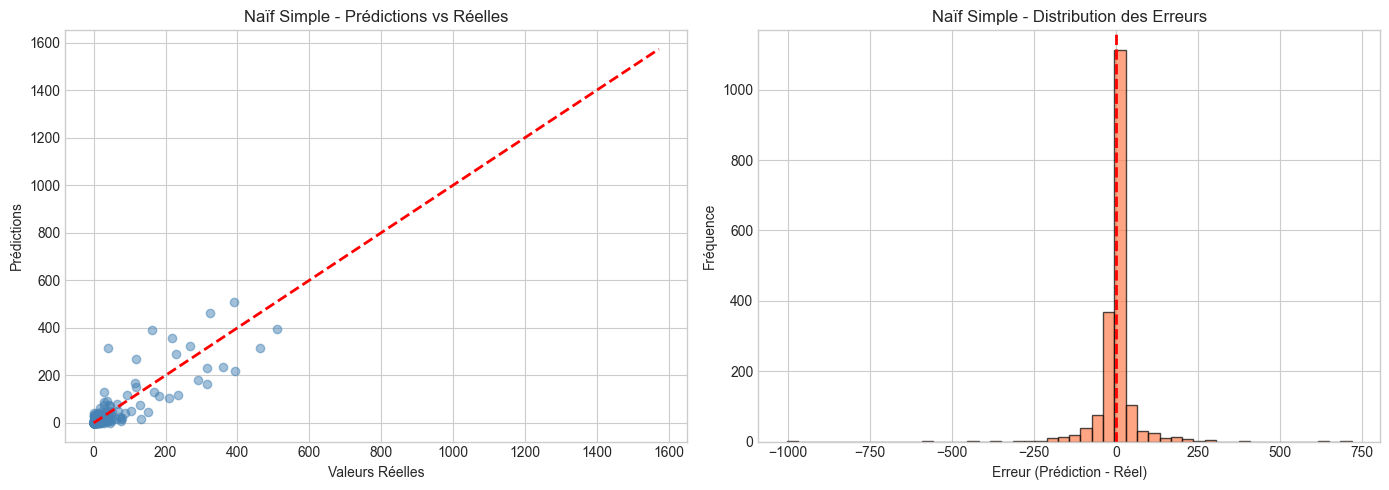

In [21]:
# Modèle Naïf Simple : prédiction = valeur de la semaine précédente (lag1)
y_pred_naive_simple = df_val_clean['TauxGrippe_lag1'].values

# Évaluation
res_naive_simple = evaluate_model(y_val.values, y_pred_naive_simple, "Naïf Simple (Persistance)")
results.append(res_naive_simple)

plot_predictions(y_val.values, y_pred_naive_simple, "Naïf Simple")

### 7.2 Modèle Naïf Saisonnier

$$\hat{y}_{T+h|T} = y_{T+h-km}$$

où m = période saisonnière (52 semaines) et k = nombre d'années complètes.


📊 Naïf Saisonnier (lag 52)
   RMSE : 222.71
   MAE  : 104.81
   R²   : -1.4943
   MAPE : 109410173616.98%


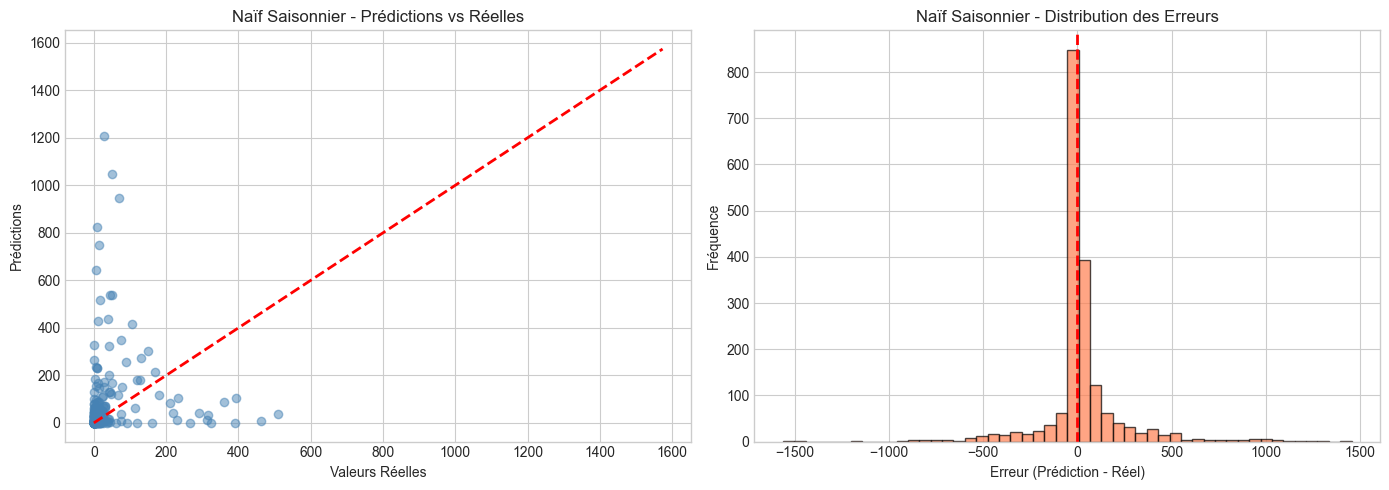

In [22]:
# Modèle Naïf Saisonnier : prédiction = valeur de la même semaine l'année précédente
# On crée un lag de 52 semaines
df_temp = df.copy()
df_temp['TauxGrippe_lag52'] = df_temp.groupby('region_name')['TauxGrippe'].shift(52)

# Filtrer sur la période de validation
df_val_seasonal = df_temp[df_temp['week'].isin(val_weeks)].dropna(subset=['TauxGrippe_lag52'])

y_true_seasonal = df_val_seasonal['TauxGrippe'].values
y_pred_naive_seasonal = df_val_seasonal['TauxGrippe_lag52'].values

if len(y_pred_naive_seasonal) > 0:
    res_naive_seasonal = evaluate_model(y_true_seasonal, y_pred_naive_seasonal, "Naïf Saisonnier (lag 52)")
    results.append(res_naive_seasonal)
    plot_predictions(y_true_seasonal, y_pred_naive_seasonal, "Naïf Saisonnier")
else:
    print("⚠️ Pas assez de données pour le modèle naïf saisonnier (nécessite 1 an d'historique)")

### 7.3 Moyenne Mobile

$$\hat{y}_{T+h|T} = \bar{y} = \frac{1}{T}(y_1 + ... + y_T)$$


📊 Moyenne Mobile (4 semaines)
   RMSE : 98.26
   MAE  : 40.33
   R²   : 0.5145
   MAPE : 21766774984.56%


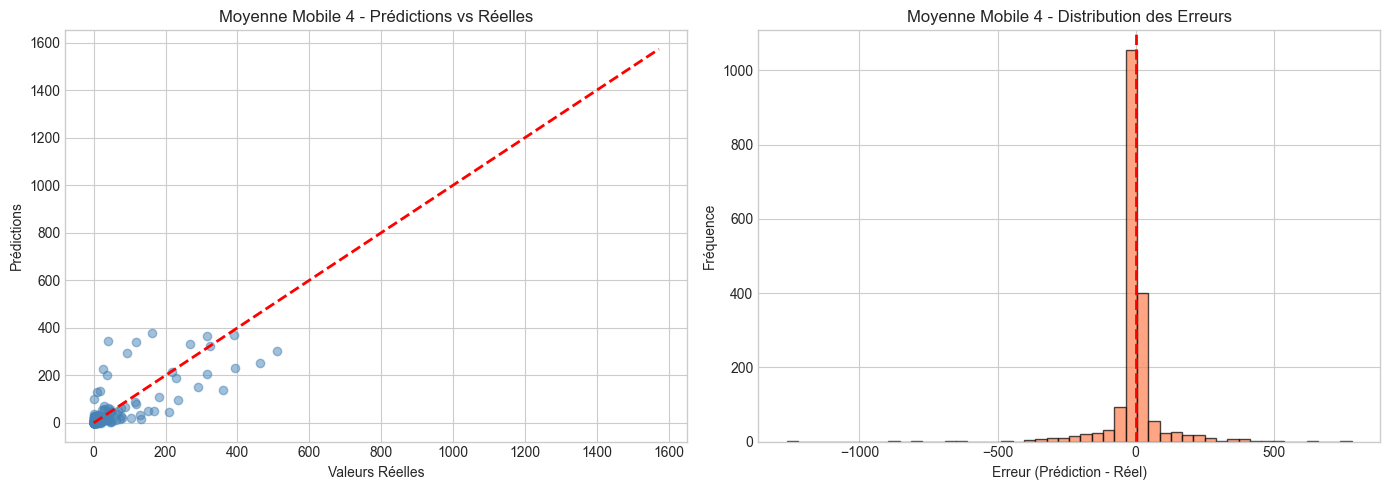

In [23]:
# Modèle Moyenne Mobile (sur 4 semaines)
y_pred_ma4 = df_val_clean['TauxGrippe_rolling_mean_4'].values

res_ma4 = evaluate_model(y_val.values, y_pred_ma4, "Moyenne Mobile (4 semaines)")
results.append(res_ma4)

plot_predictions(y_val.values, y_pred_ma4, "Moyenne Mobile 4")

### 7.4 Moyenne Historique par Région


📊 Moyenne Historique par Région
   RMSE : 142.08
   MAE  : 92.06
   R²   : -0.0152
   MAPE : 288718294412.14%


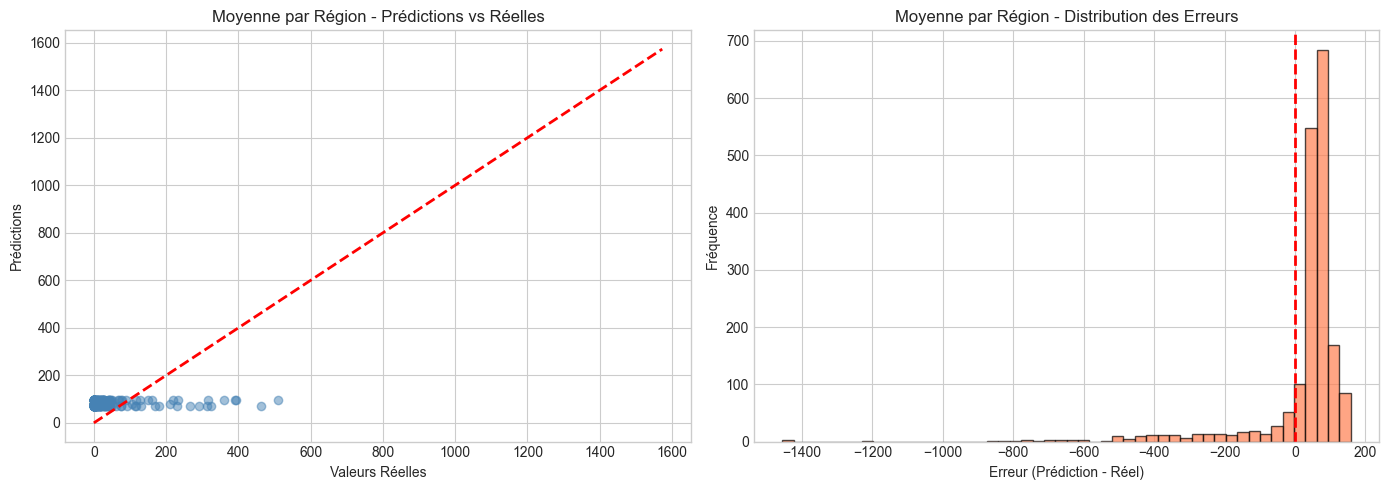

In [24]:
# Moyenne historique par région (calculée sur le train)
mean_by_region = df_train.groupby('region_name')['TauxGrippe'].mean()

# Appliquer aux données de validation
y_pred_mean_region = df_val_clean['region_name'].map(mean_by_region).values

res_mean_region = evaluate_model(y_val.values, y_pred_mean_region, "Moyenne Historique par Région")
results.append(res_mean_region)

plot_predictions(y_val.values, y_pred_mean_region, "Moyenne par Région")

### 7.5 Modèle Dérive (Drift)

$$\hat{y}_{T+h|T} = y_T + h \left( \frac{y_T - y_1}{T-1} \right)$$

In [25]:
# Modèle Dérive par région
def compute_drift_prediction(group):
    """Calcule la prédiction par dérive pour un groupe (région)."""
    y_T = group['TauxGrippe_lag1'].values
    y_1 = group['TauxGrippe_lag4'].values  # Approximation avec lag4
    T = 4  # Fenêtre de 4 semaines
    h = 1  # Horizon de 1 semaine
    drift = h * (y_T - y_1) / (T - 1)
    return y_T + drift

# Application
y_pred_drift = df_val_clean.groupby('region_name').apply(
    lambda x: pd.Series(compute_drift_prediction(x), index=x.index)
).values.flatten()

# Réordonner selon l'index original
df_val_clean['pred_drift'] = compute_drift_prediction(df_val_clean)
y_pred_drift = df_val_clean['pred_drift'].values

res_drift = evaluate_model(y_val.values, y_pred_drift, "Modèle Dérive (Drift)")
results.append(res_drift)

# Nettoyer
df_val_clean.drop('pred_drift', axis=1, inplace=True)


📊 Modèle Dérive (Drift)
   RMSE : 70.43
   MAE  : 29.52
   R²   : 0.7506
   MAPE : 19810606151.55%


---
# <span style="color: blue;">PARTIE 2 : RÉGRESSION LINÉAIRE</span>
---

## <span style="color: green;">8. Régression Linéaire</span>

### 8.1 Régression Linéaire Simple


📊 Régression Linéaire
   RMSE : 63.96
   MAE  : 37.01
   R²   : 0.7943
   MAPE : 92577247917.01%


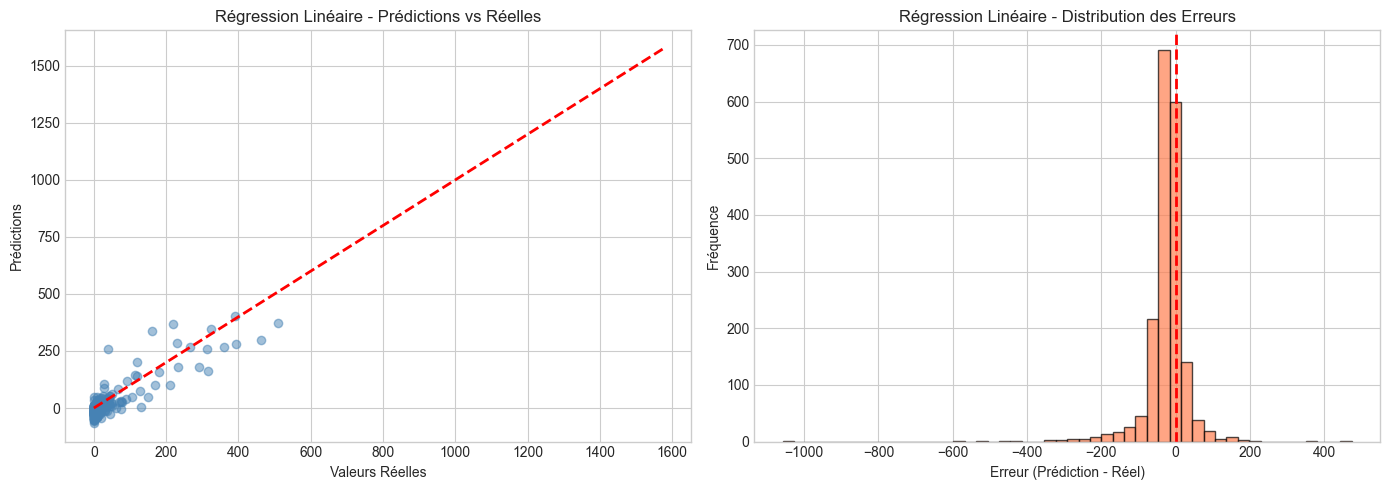

In [29]:
# Régression Linéaire simple
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

res_lr = evaluate_model(y_val.values, y_pred_lr, "Régression Linéaire")
results.append(res_lr)

plot_predictions(y_val.values, y_pred_lr, "Régression Linéaire")

In [30]:
# Coefficients les plus importants
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("📊 Top 10 coefficients (Régression Linéaire) :")
coef_df.head(10)

📊 Top 10 coefficients (Régression Linéaire) :


,feature,coefficient
21,ratio_seniors,4598.35
22,ratio_actifs,2530.20
20,ratio_jeunes,2454.84
34,region_ILE-DE-FRANCE,280.52
44,region_RHONE-ALPES,113.42
18,sin_month,-98.33
16,sin_week,93.24
36,region_LIMOUSIN,-80.14
41,region_PICARDIE,-79.54
42,region_POITOU-CHARENTES,-72.37


### 8.2 Régression Ridge (L2)


📊 Régression Ridge
   RMSE : 59.62
   MAE  : 30.82
   R²   : 0.8212
   MAPE : 61474761039.41%


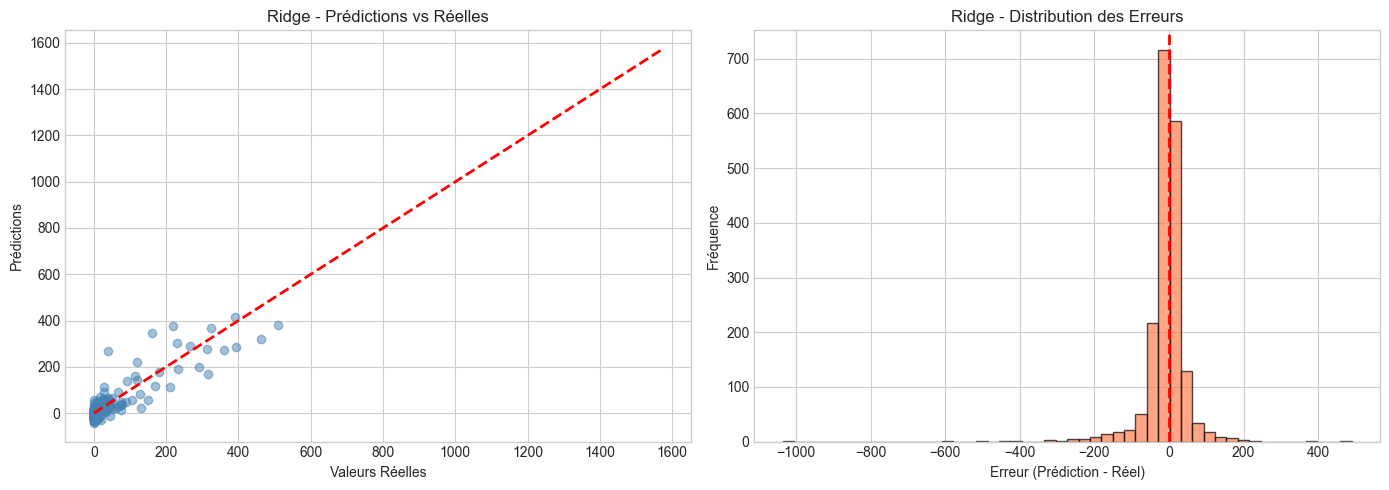

In [31]:
# Régression Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_val)

res_ridge = evaluate_model(y_val.values, y_pred_ridge, "Régression Ridge")
results.append(res_ridge)

plot_predictions(y_val.values, y_pred_ridge, "Ridge")

### 8.3 Régression Lasso (L1)

In [32]:
# Régression Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_val)

res_lasso = evaluate_model(y_val.values, y_pred_lasso, "Régression Lasso")
results.append(res_lasso)

# Features sélectionnées par Lasso
lasso_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lasso.coef_
})
n_selected = (lasso_coef['coefficient'] != 0).sum()
print(f"\n📊 Lasso a sélectionné {n_selected}/{len(X_train.columns)} features")


📊 Régression Lasso
   RMSE : 59.21
   MAE  : 29.96
   R²   : 0.8237
   MAPE : 55907383561.42%

📊 Lasso a sélectionné 40/46 features


---
# <span style="color: blue;">PARTIE 3 : MODÈLES ARIMA</span>
---

## <span style="color: green;">9. Modèles ARIMA</span>

ARIMA nécessite une série temporelle univariée. On va l'appliquer par région.

In [33]:
# Test de stationnarité (Augmented Dickey-Fuller)
def test_stationarity(series, region_name):
    """Test ADF pour vérifier la stationnarité."""
    result = adfuller(series.dropna())
    print(f"\n📊 Test ADF - {region_name}")
    print(f"   Statistique ADF : {result[0]:.4f}")
    print(f"   p-value         : {result[1]:.4f}")
    print(f"   Stationnaire    : {'Oui' if result[1] < 0.05 else 'Non'}")
    return result[1] < 0.05

# Test sur une région exemple
region_test = 'ILE-DE-FRANCE'
series_test = df_train[df_train['region_name'] == region_test]['TauxGrippe']
test_stationarity(series_test, region_test)


📊 Test ADF - ILE-DE-FRANCE
   Statistique ADF : -5.6986
   p-value         : 0.0000
   Stationnaire    : Oui


np.True_

In [34]:
# ARIMA par région (on prend quelques régions pour l'exemple)
regions_to_model = df['region_name'].unique()[:5]  # 5 premières régions

arima_predictions = []
arima_actuals = []

for region in regions_to_model:
    print(f"\n🔄 Modèle ARIMA pour {region}...")
    
    # Données de la région
    train_region = df_train[df_train['region_name'] == region]['TauxGrippe'].values
    val_region = df_val[df_val['region_name'] == region]['TauxGrippe'].values
    
    try:
        # Fit ARIMA(1,1,1) - paramètres simples
        model = ARIMA(train_region, order=(1, 1, 1))
        fitted = model.fit()
        
        # Prédictions
        predictions = fitted.forecast(steps=len(val_region))
        
        arima_predictions.extend(predictions)
        arima_actuals.extend(val_region)
        
        rmse = np.sqrt(mean_squared_error(val_region, predictions))
        print(f"   RMSE : {rmse:.2f}")
        
    except Exception as e:
        print(f"   ⚠️ Erreur : {e}")

# Évaluation globale ARIMA
if len(arima_predictions) > 0:
    res_arima = evaluate_model(np.array(arima_actuals), np.array(arima_predictions), "ARIMA(1,1,1)")
    results.append(res_arima)


🔄 Modèle ARIMA pour ALSACE...
   RMSE : 107.03

🔄 Modèle ARIMA pour AQUITAINE...
   RMSE : 89.24

🔄 Modèle ARIMA pour AUVERGNE...
   RMSE : 187.47

🔄 Modèle ARIMA pour BASSE-NORMANDIE...
   RMSE : 107.21

🔄 Modèle ARIMA pour BOURGOGNE...
   RMSE : 45.42

📊 ARIMA(1,1,1)
   RMSE : 116.72
   MAE  : 55.71
   R²   : -0.1046
   MAPE : 121514433451.66%


---
# <span style="color: blue;">PARTIE 4 : MODÈLES MACHINE LEARNING</span>
---

## <span style="color: green;">10. Random Forest</span>


📊 Random Forest
   RMSE : 61.74
   MAE  : 25.76
   R²   : 0.8083
   MAPE : 21348660997.43%


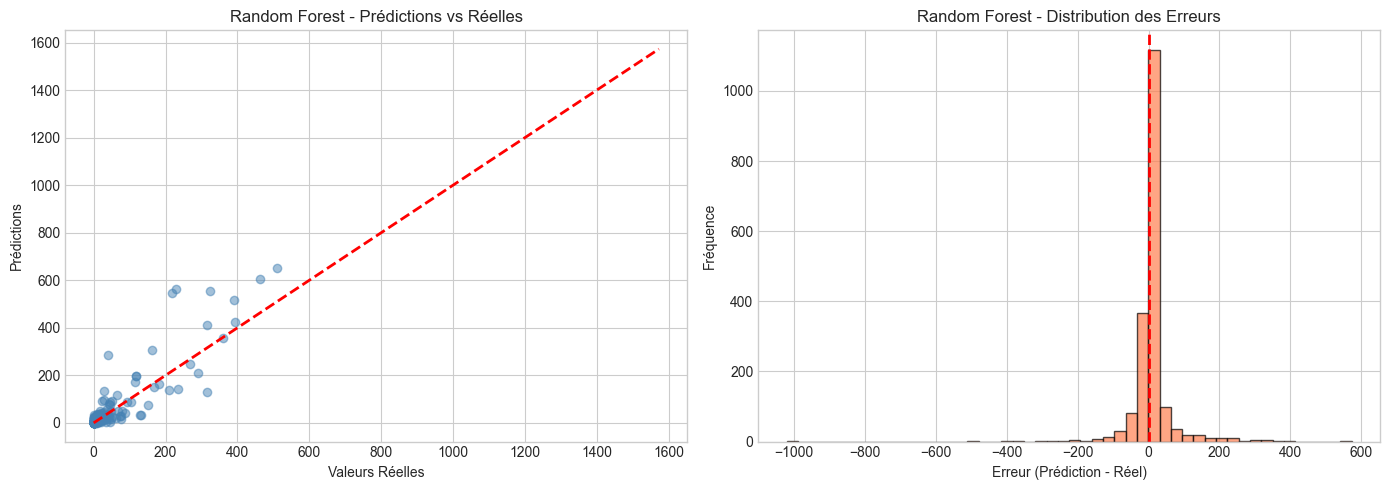

In [35]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

res_rf = evaluate_model(y_val.values, y_pred_rf, "Random Forest")
results.append(res_rf)

plot_predictions(y_val.values, y_pred_rf, "Random Forest")

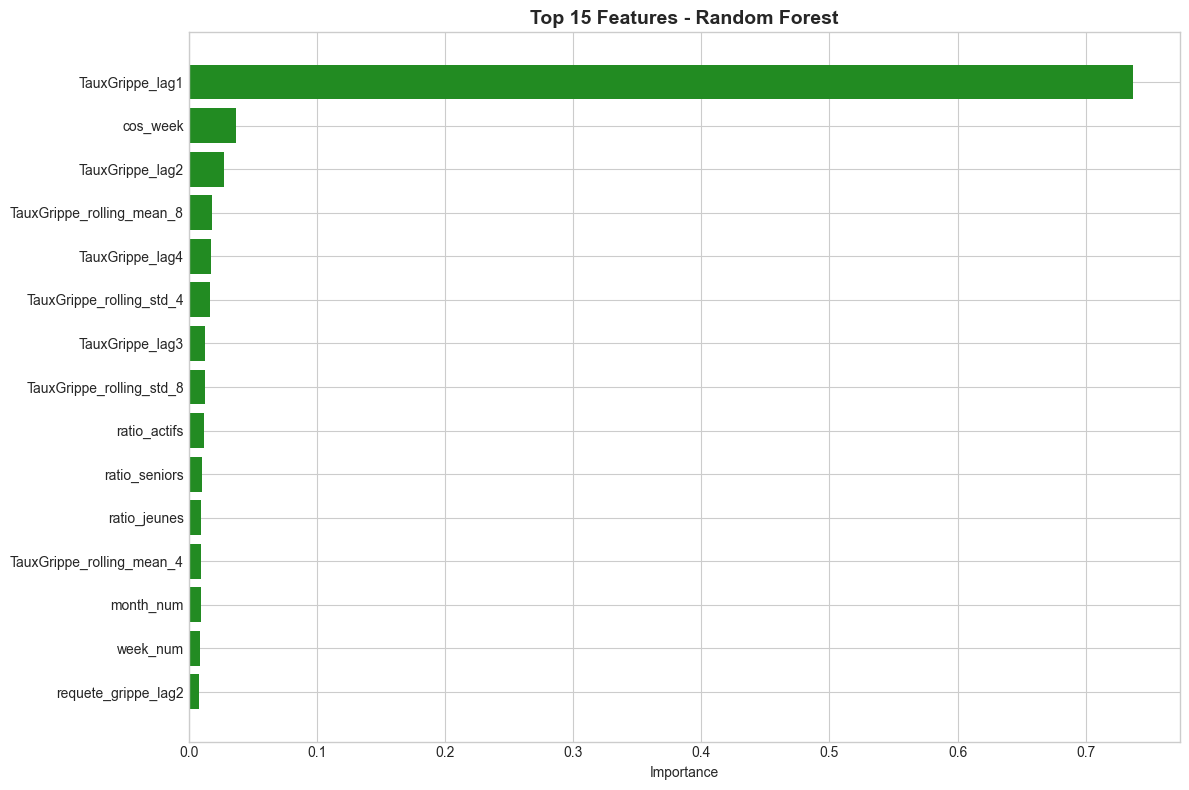

,feature,importance
0,TauxGrippe_lag1,0.74
17,cos_week,0.04
1,TauxGrippe_lag2,0.03
7,TauxGrippe_rolling_mean_8,0.02
3,TauxGrippe_lag4,0.02
8,TauxGrippe_rolling_std_4,0.02
2,TauxGrippe_lag3,0.01
9,TauxGrippe_rolling_std_8,0.01
22,ratio_actifs,0.01
21,ratio_seniors,0.01


In [36]:
# Feature Importance - Random Forest
fi_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(fi_rf['feature'][:15], fi_rf['importance'][:15], color='forestgreen')
plt.xlabel('Importance')
plt.title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

fi_rf.head(15)

## <span style="color: green;">11. XGBoost</span>


📊 XGBoost
   RMSE : 62.20
   MAE  : 26.56
   R²   : 0.8054
   MAPE : 20682431007.11%


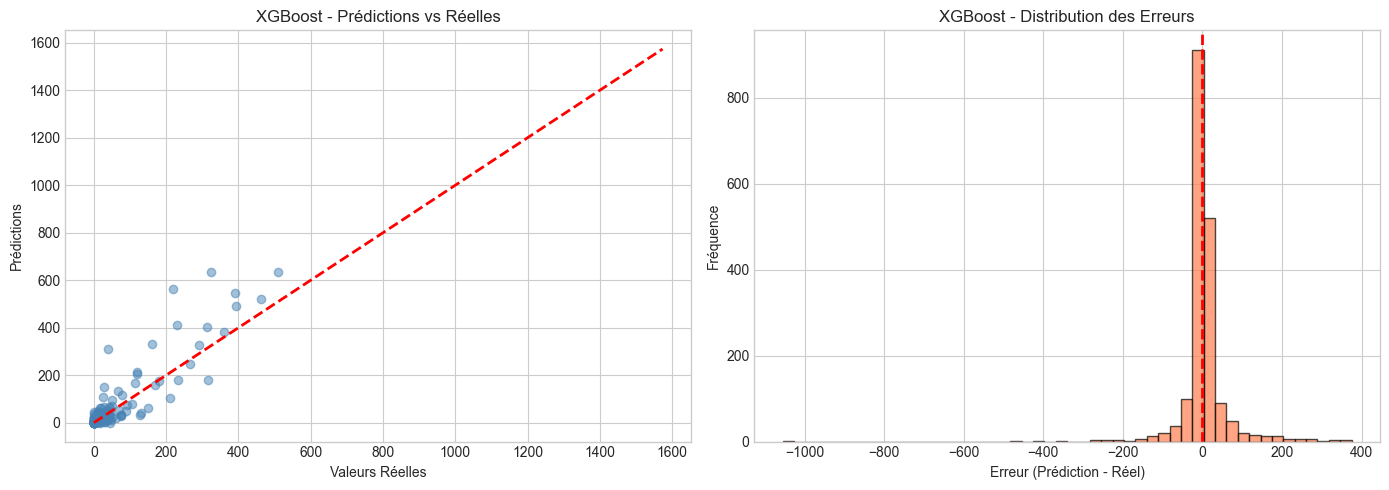

In [37]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              verbose=False)

y_pred_xgb = xgb_model.predict(X_val)

res_xgb = evaluate_model(y_val.values, y_pred_xgb, "XGBoost")
results.append(res_xgb)

plot_predictions(y_val.values, y_pred_xgb, "XGBoost")

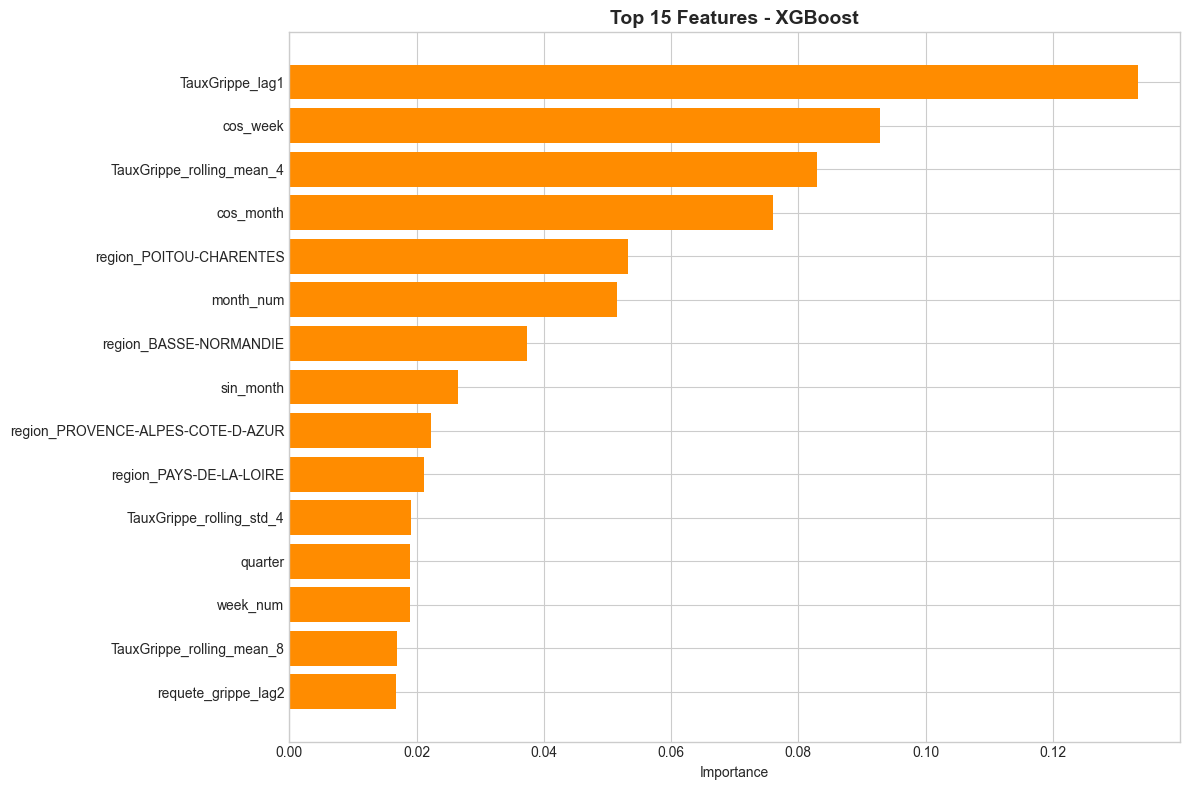

In [38]:
# Feature Importance - XGBoost
fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(fi_xgb['feature'][:15], fi_xgb['importance'][:15], color='darkorange')
plt.xlabel('Importance')
plt.title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## <span style="color: green;">12. LightGBM</span>


📊 LightGBM
   RMSE : 62.69
   MAE  : 26.26
   R²   : 0.8024
   MAPE : 21173125736.82%


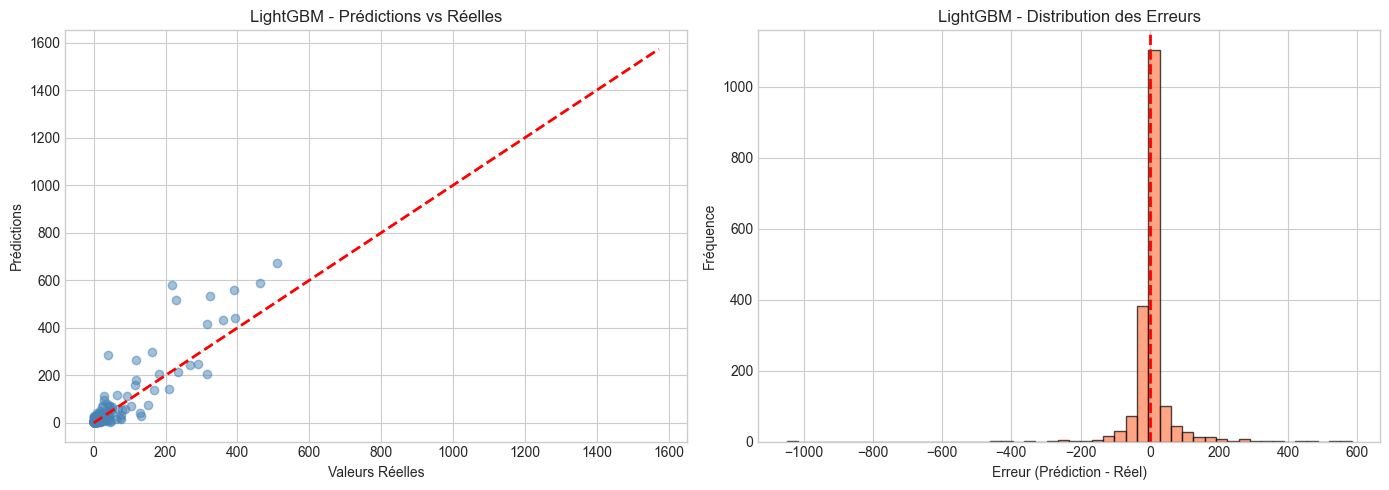

In [39]:
# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)])

y_pred_lgb = lgb_model.predict(X_val)

res_lgb = evaluate_model(y_val.values, y_pred_lgb, "LightGBM")
results.append(res_lgb)

plot_predictions(y_val.values, y_pred_lgb, "LightGBM")

---
# <span style="color: blue;">PARTIE 5 : BENCHMARK & COMPARAISON</span>
---

## <span style="color: green;">13. Tableau Récapitulatif des Performances</span>

In [40]:
# Création du DataFrame de benchmark
benchmark_df = pd.DataFrame(results)
benchmark_df = benchmark_df.sort_values('RMSE')

print("="*80)
print("                    📊 BENCHMARK DES MODÈLES")
print("="*80)
benchmark_df

                    📊 BENCHMARK DES MODÈLES


,model,RMSE,MAE,R2,MAPE
7,Régression Lasso,59.21,29.96,0.82,55907383561.42
6,Régression Ridge,59.62,30.82,0.82,61474761039.41
9,Random Forest,61.74,25.76,0.81,21348660997.43
10,XGBoost,62.20,26.56,0.81,20682431007.11
11,LightGBM,62.69,26.26,0.80,21173125736.82
0,Naïf Simple (Persistance),63.40,26.11,0.80,12889610456.98
5,Régression Linéaire,63.96,37.01,0.79,92577247917.01
4,Modèle Dérive (Drift),70.43,29.52,0.75,19810606151.55
2,Moyenne Mobile (4 semaines),98.26,40.33,0.51,21766774984.56
8,"ARIMA(1,1,1)",116.72,55.71,-0.10,121514433451.66


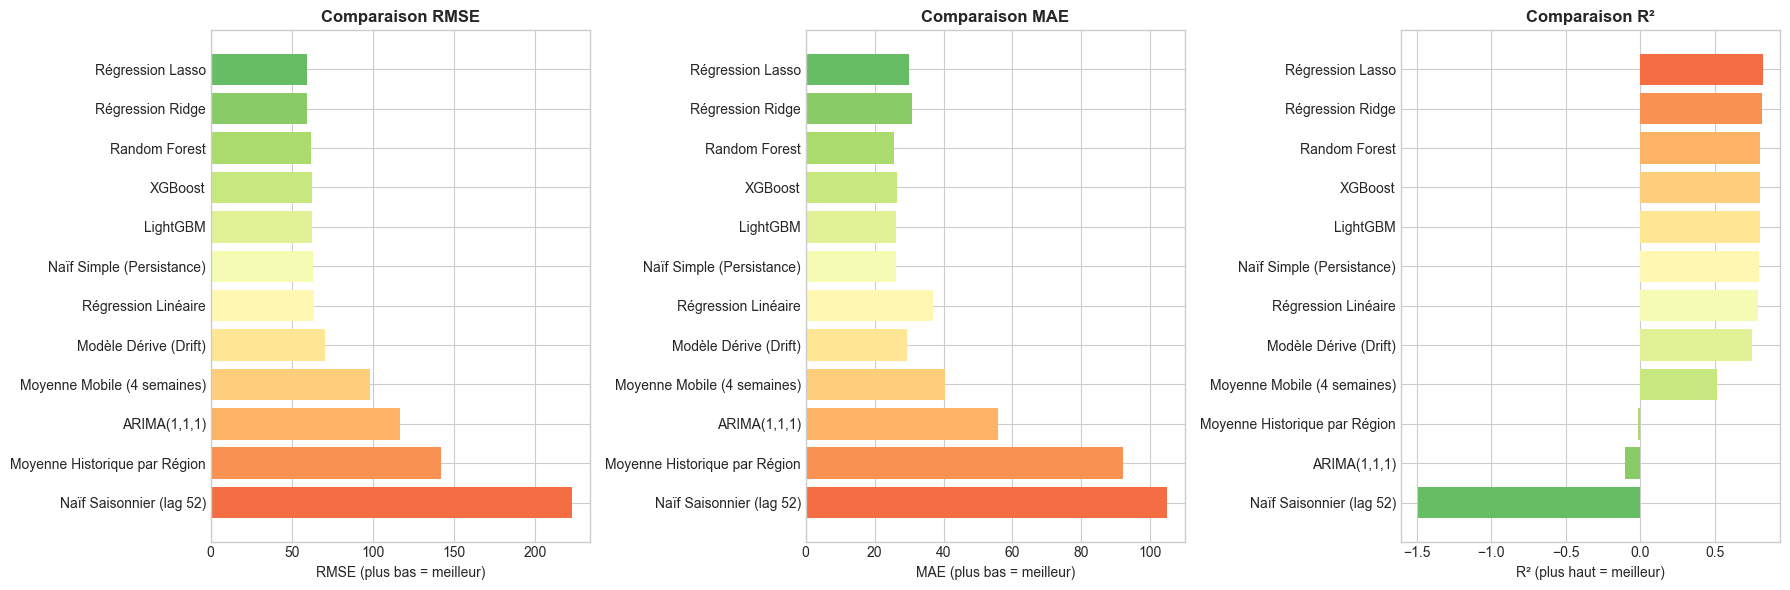

In [41]:
# Visualisation du benchmark
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(benchmark_df)))
axes[0].barh(benchmark_df['model'], benchmark_df['RMSE'], color=colors)
axes[0].set_xlabel('RMSE (plus bas = meilleur)')
axes[0].set_title('Comparaison RMSE', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# MAE
axes[1].barh(benchmark_df['model'], benchmark_df['MAE'], color=colors)
axes[1].set_xlabel('MAE (plus bas = meilleur)')
axes[1].set_title('Comparaison MAE', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

# R²
benchmark_sorted_r2 = benchmark_df.sort_values('R2', ascending=False)
colors_r2 = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(benchmark_sorted_r2)))
axes[2].barh(benchmark_sorted_r2['model'], benchmark_sorted_r2['R2'], color=colors_r2)
axes[2].set_xlabel('R² (plus haut = meilleur)')
axes[2].set_title('Comparaison R²', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('benchmark_modeles.png', dpi=150, bbox_inches='tight')
plt.show()

In [42]:
# Meilleur modèle
best_model = benchmark_df.iloc[0]

print("\n" + "="*60)
print("🏆 MEILLEUR MODÈLE")
print("="*60)
print(f"   Modèle : {best_model['model']}")
print(f"   RMSE   : {best_model['RMSE']:.2f}")
print(f"   MAE    : {best_model['MAE']:.2f}")
print(f"   R²     : {best_model['R2']:.4f}")
print(f"   MAPE   : {best_model['MAPE']:.2f}%")


🏆 MEILLEUR MODÈLE
   Modèle : Régression Lasso
   RMSE   : 59.21
   MAE    : 29.96
   R²     : 0.8237
   MAPE   : 55907383561.42%


## <span style="color: green;">14. Génération des Submissions CSV</span>

In [43]:
# Fonction pour créer un fichier submission
def create_submission(model, model_name, X_data, df_data, filename):
    """
    Crée un fichier CSV de soumission au format attendu.
    """
    predictions = model.predict(X_data)
    
    submission = pd.DataFrame({
        'Id': df_data['Id'].values,
        'week': df_data['week'].values,
        'region_name': df_data['region_name'].values,
        'TauxGrippe_pred': predictions
    })
    
    submission.to_csv(filename, index=False)
    print(f"✅ Submission sauvegardée : {filename}")
    return submission

# Créer les submissions pour les meilleurs modèles
print("\n📄 GÉNÉRATION DES FICHIERS SUBMISSION")
print("-" * 50)


📄 GÉNÉRATION DES FICHIERS SUBMISSION
--------------------------------------------------


In [44]:
# Submission Régression Lasso
sub_rl = create_submission(lasso, "Régression Lasso", X_val, df_val_clean, "submission_lasso.csv")
sub_rl.head()

✅ Submission sauvegardée : submission_lasso.csv


,Id,week,region_name,TauxGrippe_pred
0,7349,201021,ALSACE,-4.77
1,7327,201022,ALSACE,-11.43
2,7305,201023,ALSACE,-1.57
3,7283,201024,ALSACE,-12.39
4,7261,201025,ALSACE,-20.51


In [45]:
# Fonction pour créer un fichier submission
def create_submission(model, model_name, X_data, df_data, filename):
    """
    Crée un fichier CSV de soumission au format attendu.
    """
    predictions = model.predict(X_data)
    
    submission = pd.DataFrame({
        'Id': df_data['Id'].values,
        'TauxGrippe': predictions
    })
    
    submission.to_csv(filename, index=False)
    print(f"✅ Submission sauvegardée : {filename}")
    return submission

In [46]:
# Submission Régression Lasso
sub_lasso = create_submission(lasso, "Régression Lasso", X_val, df_val_clean, "submission_lassov1.csv")
sub_lasso.head()

✅ Submission sauvegardée : submission_lassov1.csv


,Id,TauxGrippe
0,7349,-4.77
1,7327,-11.43
2,7305,-1.57
3,7283,-12.39
4,7261,-20.51


## <span style="color: green;">15. Sauvegarde du Benchmark</span>

In [ ]:
# Sauvegarde du tableau de benchmark
benchmark_df.to_csv('benchmark_modeles.csv', index=False)
print("✅ Benchmark sauvegardé : benchmark_modeles.csv")

# Affichage final
print("\n" + "="*80)
print("                    ✅ MODÉLISATION TERMINÉE")
print("="*80)
print("\n📁 Fichiers générés :")
print("   • benchmark_modeles.csv")
print("   • benchmark_modeles.png")
print("   • submission_random_forest.csv")
print("   • submission_xgboost.csv")
print("   • submission_lightgbm.csv")

---
## <span style="color: green;">16. Préparation du Test et Submission </span>